In [66]:
import librosa
import librosa.display
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

from carriers import sawtooth_osc, square_osc

In [54]:
# Basic params
sr = 44100
hop_length = 256
n_fft = 2048

In [67]:
# Utils
def compare_stft(source, output):
    fig, axes = plt.subplots(1,2, figsize=(22,8))
    
    stft_source = librosa.stft(source, window='hann', n_fft=n_fft, hop_length=hop_length)
    stft_source = np.abs(stft_source)
    img = librosa.display.specshow(librosa.amplitude_to_db(stft_source, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[0])
    axes[0].set_title("Source")
    plt.colorbar(img, ax=axes[0], format="%+2.f dB")

    stft_output = librosa.stft(output, window='hann', n_fft=n_fft, hop_length=hop_length)
    stft_output = np.abs(stft_output)
    img = librosa.display.specshow(librosa.amplitude_to_db(stft_output, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[1])
    axes[1].set_title("Output")
    plt.colorbar(img, ax=axes[1], format="%+2.f dB")

## Load Audio

In [69]:
# Audio Selection
import ipywidgets as widgets

w = widgets.Dropdown(
    options=[('dog_sound', 'dog_sound'), 
             ('suzanne', 'suzanne')],
    value='dog_sound',
    description='Select audio:',
)
ipd.display(w)

Dropdown(description='Select audio:', options=(('dog_sound', 'dog_sound'), ('suzanne', 'suzanne')), value='dog…

In [74]:
# Load Audio
modulator_x, _ = librosa.load("./audio/{}.wav".format(w.value), sr=sr) 
print(modulator_x.shape)
ipd.Audio(modulator_x, rate=sr)

(218170,)


## Basic Channel Vocoder

### 1. 전체에 stft 한 뒤 hadarmard 곱

In [150]:
class Channel_Vocoder():
    def __init__(self, sr, n_fft=1024):
        self.sr = sr
        self.hop_length = n_fft//4
        self.n_fft = n_fft
        
    def __call__(self, modulator_x, carrier_type='sawtooth', carrier_f0=440):
        # Set carrier signal
        dur = modulator_x.shape[0]
        if carrier_type == 'sawtooth':
            carrier_x = sawtooth_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        elif carrier_type == 'square':
            carrier_x = square_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        else:
            # TODO: 여기 종류 더 많아지면 개선 필요
            print("Carrier Type Error")
            
        # STFT
        modulator_y = librosa.stft(modulator_x, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
        carrier_y = librosa.stft(carrier_x, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
        
        # Phase vocoder
        carrier_y *= 2
        modulator_y = librosa.phase_vocoder(modulator_y, rate=2.0, hop_length=self.hop_length)
        carrier_y = librosa.phase_vocoder(carrier_y, rate=2.0, hop_length=self.hop_length)
        
        # Muliply freq components
        y = np.multiply(modulator_y, carrier_y) # 여기서 freq를 좀 바꿔가면서 실험 -> shift 정도를 랜덤으로
        return librosa.istft(y)
        

### - carrier f0 = 440

In [151]:
n_fft = 1024
channel_vocoder = Channel_Vocoder(sr=sr, n_fft=n_fft)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440)
ipd.Audio(output, rate=sr)

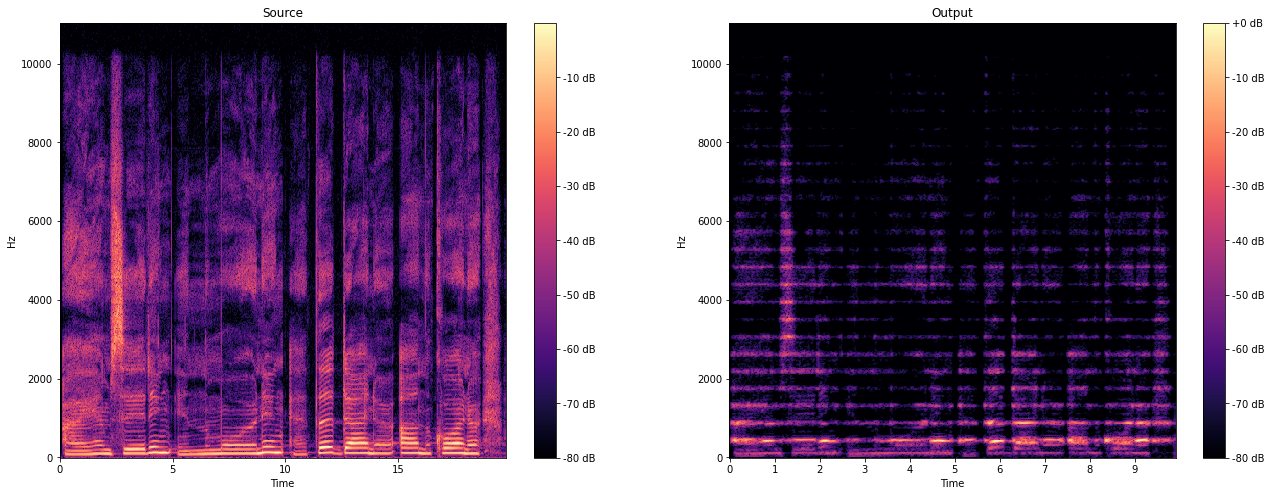

In [140]:
compare_stft(modulator_x, output)

### - carrier f0 = 880

In [143]:
channel_vocoder = Channel_Vocoder(sr=sr, n_fft=n_fft)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=880)
ipd.Audio(output, rate=sr)

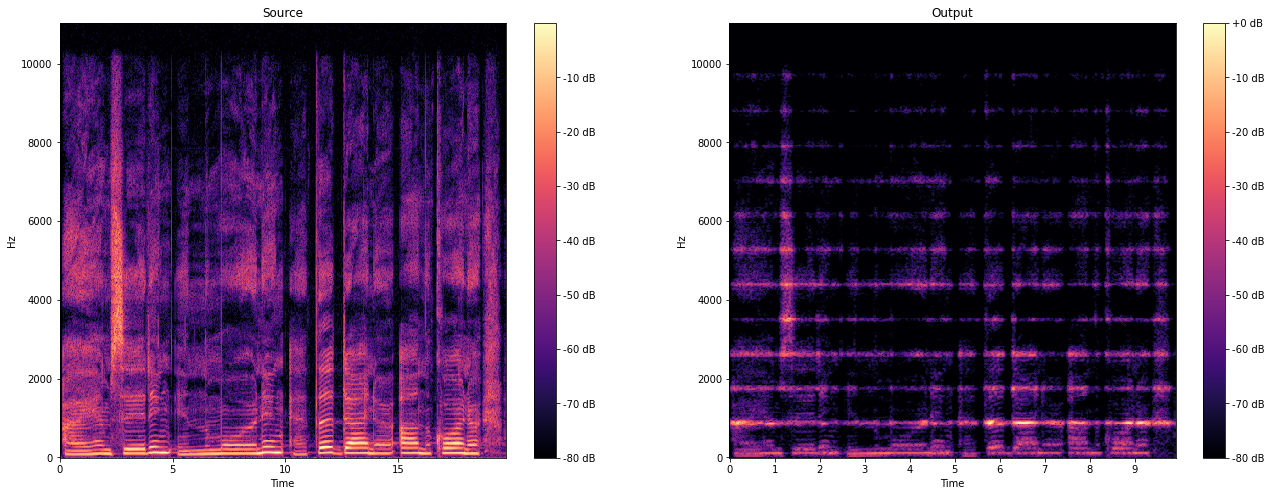

In [144]:
compare_stft(modulator_x, output)

### 2. Carrier Pitch Shifting

In [127]:
y, sr = librosa.load(librosa.ex('choice'))
y_third = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)
ipd.Audio(y_third, rate=sr)

In [128]:
ipd.Audio(y, rate=sr)

## Formant Shifting